In [1]:
library(tidyverse)
library(clusterProfiler)
library(BiocParallel)
library(parallel)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE
clusterProfiler v3.14.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:purrr’:

    simplify



In [2]:
n_cores <- detectCores() - 2
BiocParallel::register(MulticoreParam(n_cores))

In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")

In [4]:
dset_idx <- 1

In [5]:
network_mm_gs_df <- read_tsv(paste0(dirs$analysis_dir, "/network/", unified_dsets[dset_idx], "_gene_mm_gs.tsv"))
network_me_sig_df <- read_tsv(paste0(dirs$analysis_dir, "/network/", unified_dsets[dset_idx], "_eigengene_traits.tsv"))
gene2id <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/hugo2entrez.tsv"))

Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character(),
  module = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  module = col_character(),
  figo_stage_1_cor = col_double(),
  figo_stage_2_cor = col_double(),
  figo_stage_3_cor = col_double(),
  figo_stage_4_cor = col_double(),
  figo_stage_1_pval = col_double(),
  figo_stage_2_pval = col_double(),
  figo_stage_3_pval = col_double(),
  figo_stage_4_pval = col_double(),
  figo_stage_1_qval = col_double(),
  figo_stage_2_qval = col_double(),
  figo_stage_3_qval = col_double(),
  figo_stage_4_qval = col_double(),
  vital_hr = col_double(),
  vital_dev_cor = col_double(),
  vital_pval = col_double(),
  vital_qval = col_double()
)
Parsed with column specification:
cols(
  hugo_symbol = col_character(),
  entrez_gene_id = col_double()
)


In [71]:
target_trait <- "figo_stage_1"
trait_qval <- paste0(target_trait, "_qval")
trait_cor <- paste0(target_trait, "_cor")

trait_sig_df <- network_me_sig_df %>%
    dplyr::filter(!!as.name(trait_qval) < 0.05) %>%
    dplyr::select(one_of(c("module", trait_cor, trait_qval))) %>%
    dplyr::rename_if(startsWith(colnames(.), target_trait), ~ gsub("^", "module_", .)) %>%
    inner_join(network_mm_gs_df, by = "module") %>%
    # Only care about gene-module corr. with the ME of its assigned module
    dplyr::mutate(mm_cor = !!as.name(paste0(.$module, "_cor"))) %>%
    dplyr::mutate(mm_pval = !!as.name(paste0(.$module, "_pval"))) %>%
#     dplyr::select(geneID, module, mm_cor, everything())
    dplyr::select(one_of(c("geneID", "module", "mm_cor", "mm_pval", paste0("module_", trait_cor), paste0("module_", trait_qval))))

In [7]:
trait_sig_entrez_df <- trait_sig_df %>%
    inner_join(gene2id, by = c("geneID" = "hugo_symbol")) %>%
    dplyr::select(geneID, entrez_gene_id, everything()) %>%
    dplyr::filter((abs(mm_cor) > 0.50) & (mm_pval < 0.05))

In [60]:
# trait_sig_entrez_df
go_res <- enrichGO(trait_sig_entrez_df$entrez_gene_id, "org.Hs.eg.db", ont = "ALL", readable = TRUE)
# head(go_res)

In [64]:
go_df <- tibble(type = go_res$Description, count = go_res$Count, qval = go_res$qvalue, ont = go_res$ONTOLOGY)

In [65]:
go_df

type,count,qval,ont
<chr>,<int>,<dbl>,<fct>
O-glycan processing,7,5.539150e-11,BP
innate immune response-activating signal transduction,9,9.499974e-10,BP
protein O-linked glycosylation,7,9.499974e-10,BP
activation of innate immune response,9,9.499974e-10,BP
stimulatory C-type lectin receptor signaling pathway,7,9.499974e-10,BP
innate immune response activating cell surface receptor signaling pathway,7,9.540481e-10,BP
positive regulation of innate immune response,9,2.916598e-09,BP
regulation of innate immune response,9,1.160608e-08,BP
protein glycosylation,7,1.564879e-07,BP


Saving 6.67 x 6.67 in image


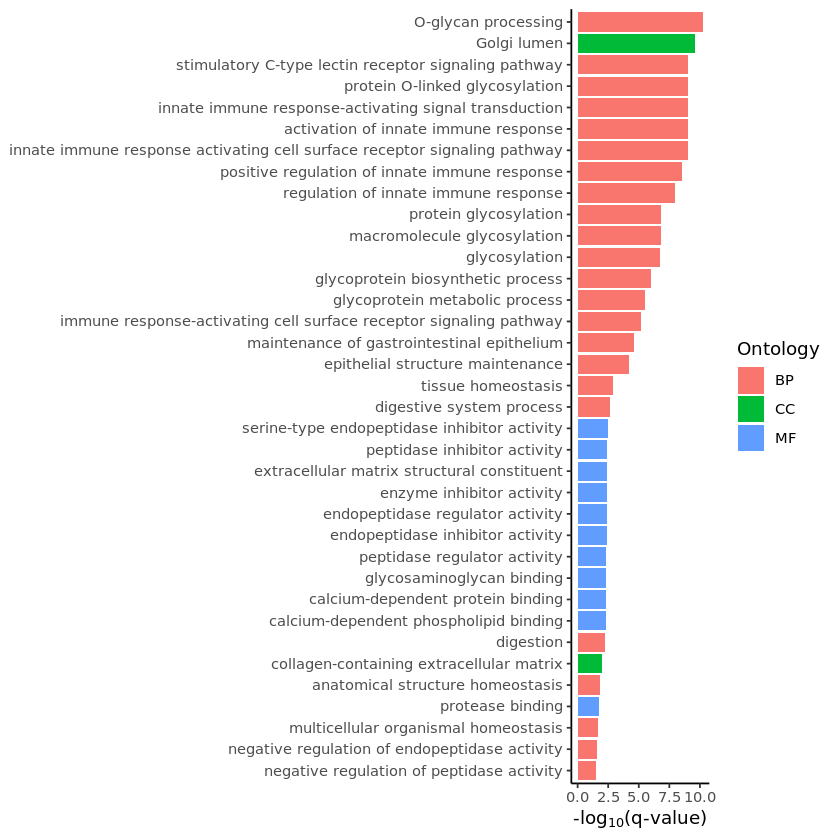

In [69]:
ggplot(go_df) +
    geom_bar(aes(x = reorder(type, (-log10(qval))), y = -log10(qval), fill = ont), stat = "identity") +
    theme_classic() +
    theme(
        axis.title.y = element_blank()
    ) +
    labs(y = expression("-log"[10]*"(q-value)"), fill = "Ontology") +
    coord_flip()
ggsave(filename = paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx], "_", target_trait, "_gene_enrichment.png"), last_plot())